In [1]:
#Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from skimage.transform import rescale
import skimage.color as color
import cv2
from PIL import Image
from skimage.external import tifffile
from skimage.transform import resize

import tensorflow as tf
import keras
from keras import backend
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D,GlobalAveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model, load_model
from keras.optimizers import SGD, Adam
from keras.applications import ResNet50, VGG16, MobileNet, Xception, DenseNet121
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.backend import clear_session

## Image Augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import argparse

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import cv2
import os
from os import listdir
from tqdm import tqdm
import time
import csv
import pickle

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session

Using TensorFlow backend.


In [3]:
#Define model parameter 

INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
EPOCHS = 2
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 2 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

TRAIN_PATH = 'data/train-jpg'
TEST_PATH = 'data/test-jpg'

TRAIN_CSV_PATH = 'data/train_v2.csv'
TEST_CSV_PATH = 'data/sample_submission_v2.csv'

In [4]:
# Construct dataframes holding training and test data information

df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print()
print(df_test.head())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road

   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [5]:
df_test.head()

,image_name,tags
0,test_0.jpg,"[primary, clear, agriculture, road, water]"
1,test_1.jpg,"[primary, clear, agriculture, road, water]"
2,test_2.jpg,"[primary, clear, agriculture, road, water]"
3,test_3.jpg,"[primary, clear, agriculture, road, water]"
4,test_4.jpg,"[primary, clear, agriculture, road, water]"


In [6]:
df_test.shape

(61191, 2)

In [7]:
# These files are numpy Arrays with shape Nx1
X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist())

In [9]:
# There are 17 Labels and each image is tagged with multiple labels
# Lets print out the unique label list

labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


conventional_mine is tagged least no of times: 99
primary is tagged max no of times: 37512


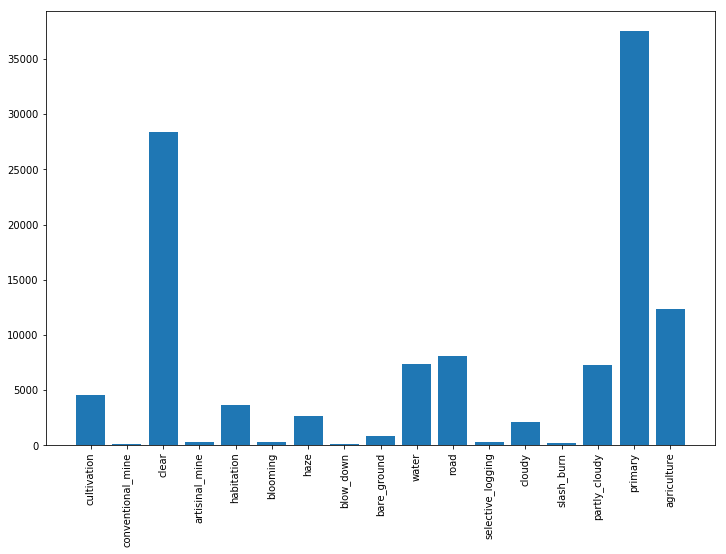

In [10]:
#Distribution of the labels :

plt.figure(figsize=(12, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [11]:
#Define Mobile Net model :

def create_model():
    img = Input(shape = (128, 128, 3))
    model_mob = MobileNet(include_top=False, weights='imagenet', input_tensor=img, input_shape=None, pooling='avg')

    final_layer = model_mob.layers[-1].output
    dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
    output_layer = Dense(17, activation = 'sigmoid')(dense_layer_1)

    model = Model(input = model_mob.input, output = output_layer)

    return model

clear_session()

model = create_model()
model.summary()

/usr/local/lib/python3.5/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [12]:
#Define evaluation metric - f2 score :

def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [ ]:
#Run the model  with k-fold cross validation:

num_fold = 0
EPOCHS = 50

y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
    y_test.append(p_test)
    num_fold+=1

Found 20239 validated image filenames belonging to 17 classes.
Found 20240 validated image filenames belonging to 17 classes.
Found 61191 validated image filenames belonging to 17 classes.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Epoch 1/50
159/159 [==============================] - 150s 942ms/step - loss: 0.1934 - f2_score: 0.7977 - val_loss: 0.2733 - val_f2_score: 0.7285
Epoch 2/50
159/159 [==============================] - 135s 850ms/step - loss: 0.1174 - f2_score: 0.8645 - val_loss: 0.1398 - val_f2_score: 0.8477
Epoch 3/50
159/159 [==============================] - 137s 860ms/step - loss: 0.1081 - f2_score: 0.8773 - val_loss: 0.0964 - val_f2_score: 0.8727
Epoch 4/50
159/159 [==============================] - 135s 850ms/step - loss: 0.1039 - f2_score: 0.8813 - val_loss: 0.1454 - val_f2_score: 0.8769
Epoch 5/50
159/159 [==============================] - 135s 848ms/step - loss: 0.1006 - f2_score: 0.8853 - val_loss: 0.1163 - val_f2_score: 0.8856
Epoch 6/50
159/159 [==============================] - 134s 845ms/step - loss: 0.0985 - f2_score: 0.8865 - val_loss: 0.0867 - val_f2_score: 0.8900
Epoch 7/50
159/159 [==============================] - 136s 856ms/step - loss: 0.0953 - f2_score: 0.8903 - val_loss: 0.1215 -

/usr/local/lib/python3.5/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Epoch 1/50
 69/159 [============>.................] - ETA: 1:14 - loss: 0.2908 - f2_score: 0.7423

In [17]:
# Average the k results obtained from k-fold cross validation

result = np.array(y_test[0])
for i in range(1, NFOLDS):
    result += np.array(y_test[i])
result /= NFOLDS
result = pd.DataFrame(result, columns = labels)
result.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.000882,0.000205,0.000296,0.009190,0.000427,0.982471,0.000660,0.000112,0.001640,0.000319,0.003950,0.002227,0.999936,0.001157,0.001334,0.000341,0.001176
1,0.005979,0.000796,0.000483,0.016046,0.004675,0.993903,0.002476,0.000078,0.008255,0.001928,0.003110,0.003847,0.999662,0.007284,0.015524,0.000339,0.004722
2,0.006050,0.000126,0.000510,0.000370,0.000444,0.000291,0.001739,0.000738,0.005822,0.005035,0.000335,0.997362,0.998415,0.007003,0.002690,0.000373,0.036711
3,0.243201,0.000901,0.007189,0.006202,0.001951,0.525588,0.000393,0.000440,0.141288,0.002951,0.002359,0.451764,0.999862,0.033785,0.015539,0.001778,0.021101
4,0.010942,0.000208,0.000988,0.000047,0.000355,0.000193,0.166443,0.000179,0.002100,0.006678,0.001854,0.877271,0.837704,0.021272,0.000695,0.000441,0.021323


In [18]:
#Pickling the result df
import pickle
pickle1_out = open('result_mb.pickle', 'wb')
pickle.dump(result, pickle1_out, protocol=4)
pickle1_out.close()

In [19]:
result.shape

(61191, 17)

In [20]:
df_test.head()

,image_name,tags
0,test_0.jpg,"[primary, clear, agriculture, road, water]"
1,test_1.jpg,"[primary, clear, agriculture, road, water]"
2,test_2.jpg,"[primary, clear, agriculture, road, water]"
3,test_3.jpg,"[primary, clear, agriculture, road, water]"
4,test_4.jpg,"[primary, clear, agriculture, road, water]"


In [21]:
#Create flags for predicted labels and subission file for kaggle submission

preds = []
for i in range(result.shape[0]):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.to_csv('submit.csv', index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
